# Policy Optimization

In [ ]:
## Colab users ##

# Clone the repository
import os

git_path = '/content/balloon-outreach'
if os.path.exists(git_path):
    print("✅ Found:", git_path)
else:
    print("❌ Not found:", git_path)
    !git clone https://github.com/sdean-group/balloon-outreach.git
    %cd balloon-outreach
    !git checkout main

In [ ]:
# Install required packages
!pip install -r requirements.txt

In [ ]:
import sys
sys.path.append('/content/balloon-outreach/')

In [ ]:
from google.colab import drive
import gdown
import os

# 1. Mount your Drive
drive.mount('/content/drive')

# 2. Check existence
if os.path.exists('/content/drive/My Drive/era5_data.nc'):
    print("✅ Found:", '/content/drive/My Drive/era5_data.nc')
    datapath = '/content/drive/My Drive/era5_data.nc'

elif os.path.exists("/content/balloon-outreach/era5_data.nc"):
    print("✅ Found:", "/content/balloon-outreach/era5_data.nc")
    datapath = "/content/balloon-outreach/era5_data.nc"

else:
    print("❌ Not found")
    # Download ERA5 data
    file_id = "1Y5ocrCH0TVf9ZDkVGaJ03ftUrtKEVxIf"
    url = f"https://drive.google.com/uc?id={file_id}"
    output = "era5_data.nc"
    gdown.download(url, output, quiet=False)
    datapath = "/content/balloon-outreach/era5_data.nc"


In [2]:
import PO.logz as logz
import PO.utils as utils
import PO.optimizers as optimizers
from PO.policies import *

from env.balloon_env import BalloonERAEnvironment
import xarray as xr
import datetime as dt   
import time

In [ ]:
class Worker(object):
    """ 
    Object class for rollout generation.
    """

    def __init__(self, policy_params = None,
                       rollout_length=100,
                       delta_std=0.02):

        # initialize environment for worker
        ds = xr.open_dataset(datapath, engine="netcdf4")
        start_time = dt.datetime(2024, 7, 1, 0, 0)

        #This is Ithaca
        initial_lat = 42.6
        initial_lon = -76.5
        initial_alt = 10.0
        target_lat = 70
        target_lon = -90
        target_alt = 12.0
        time_step = 120 #120 seconds
        
        self.env = BalloonERAEnvironment(ds=ds, 
                                         start_time=start_time, add_noise=False, initial_lat=initial_lat, 
                                         initial_lon=initial_lon, initial_alt=initial_alt, 
                                         target_lat=target_lat, target_lon=target_lon,target_alt=target_alt, dt=time_step, viz=False)
    
        self.policy_params = policy_params
        if policy_params['type'] == 'linear':
            self.policy = LinearPolicy(policy_params)
        else:
            raise NotImplementedError
            
        self.delta_std = delta_std
        self.rollout_length = rollout_length

        
    def get_weights_plus_stats(self):
        """ 
        Get current policy weights and current statistics of past states.
        """
        assert self.policy_params['type'] == 'linear'
        return self.policy.get_weights_plus_stats()
    

    def rollout(self, rollout_length = None):
        """ 
        Performs one rollout of maximum length rollout_length. 
        """
        
        if rollout_length is None:
            rollout_length = self.rollout_length

        total_reward = 0.
        steps = 0

        ob = self.env.reset()
        for i in range(rollout_length):
            action = self.policy.act(ob)
            ob, reward, done, _ = self.env.step(action)
            steps += 1
            total_reward += reward
            if done:
                break
            
        return total_reward, steps

    def do_rollouts(self, w_policy, num_rollouts = 1, evaluate = False):
        """ 
        Generate multiple rollouts with a policy parametrized by w_policy.
        """

        rollout_rewards =[]
        deltas_arr = []
        steps = 0
        #print(num_rollouts)
        for i in range(num_rollouts):

            if evaluate:
                self.policy.update_weights(w_policy)
                deltas_arr.append(-1)
                
                # set to false so that evaluation rollouts are not used for updating state statistics
                self.policy.update_filter = False

                # for evaluation we use rge default rollout length 100
                reward, r_steps = self.rollout(rollout_length = self.rollout_length)
                rollout_rewards.append(reward)
                
            else:
                delta = np.random.randn(w_policy.size).astype(np.float64)
                
                deltas_arr.append(delta)
                delta = (self.delta_std * delta).reshape(w_policy.shape)
                

                # set to true so that state statistics are updated 
                self.policy.update_filter = True

                # compute reward and number of timesteps used for positive perturbation rollout
                self.policy.update_weights(w_policy + delta)
                pos_reward, pos_steps  = self.rollout()

                # compute reward and number of timesteps used for negative pertubation rollout
                self.policy.update_weights(w_policy - delta)
                neg_reward, neg_steps = self.rollout() 
                steps += pos_steps + neg_steps

                rollout_rewards.append([pos_reward, neg_reward])
                            
        return {'deltas_arr': deltas_arr, 'rollout_rewards': rollout_rewards, "steps" : steps}
    
    def stats_increment(self):
        self.policy.observation_filter.stats_increment()
        return

    def get_weights(self):
        return self.policy.get_weights()
    
    def get_filter(self):
        return self.policy.observation_filter

    def sync_filter(self, other):
        self.policy.observation_filter.sync(other)
        return

    #This is needed for pretrained models
    #def stats_update(self,mean,std):
    #    self.policy.observation_filter.stats_update(mean,std)
    #    return

In [16]:
class ARSLearner(object):
    """ 
    Object class implementing the ARS algorithm.
    """

    def __init__(self, env=BalloonERAEnvironment,
                 policy_params=None, 
                 num_deltas=8, 
                 deltas_used=4,
                 delta_std=0.02, 
                 logdir=None, 
                 rollout_length=100,
                 step_size=0.01,
                 params=None):

        logz.configure_output_dir(logdir)
        logz.save_params(params)
        
        
        self.timesteps = 0
        self.action_size = policy_params['ac_dim']
        self.ob_size = policy_params['ob_dim']
        self.num_deltas = num_deltas
        self.deltas_used = deltas_used
        self.rollout_length = rollout_length
        self.step_size = step_size
        self.delta_std = delta_std
        self.logdir = logdir
        self.params = params
        self.max_past_avg_reward = float('-inf')
        self.num_episodes_used = float('inf')
        
        
        # initialize worker
        print('Initializing worker.') 
        self.my_worker = Worker(policy_params=policy_params,
                                rollout_length=rollout_length,
                                delta_std=delta_std)


        # initialize policy 
        if policy_params['type'] == 'linear':
            self.policy = LinearPolicy(policy_params)
            self.w_policy = self.policy.get_weights()
        else:
            raise NotImplementedError
            
        # initialize optimization algorithm
        self.optimizer = optimizers.SGD(self.w_policy, self.step_size)        
        print("Initialization of ARS complete.")

    def aggregate_rollouts(self, num_rollouts = None, evaluate = False):
        """ 
        Aggregate update step from rollouts.
        """

        if num_rollouts is None:
            num_deltas = self.num_deltas
        else:
            num_deltas = num_rollouts
            
        # put policy weights in the object store
        policy = self.w_policy

        t1 = time.time()
        num_rollouts = int(num_deltas)
            
        # generation of rollouts
        result = self.my_worker.do_rollouts(policy,
                                            num_rollouts = num_rollouts,
                                            evaluate=evaluate)
        rollout_rewards, deltas_arr = [], []
        if not evaluate:
            self.timesteps += result["steps"]
        deltas_arr += result['deltas_arr']
        rollout_rewards += result['rollout_rewards']

        rollout_rewards = np.array(rollout_rewards, dtype = np.float64)
        
        print('Maximum reward of collected rollouts:', rollout_rewards.max())
        t2 = time.time()

        print('Time to generate rollouts:', t2 - t1)

        if evaluate:
            return rollout_rewards

        # select top performing directions if deltas_used < num_deltas
        max_rewards = np.max(rollout_rewards, axis = 1)
        if self.deltas_used > self.num_deltas:
            self.deltas_used = self.num_deltas
            
        idx = np.arange(max_rewards.size)[max_rewards >= np.percentile(max_rewards, 100*(1 - (self.deltas_used / self.num_deltas)))]
        rollout_rewards = rollout_rewards[idx,:]
        
        # normalize rewards by their standard deviation
        rollout_rewards /= np.std(rollout_rewards)

        t1 = time.time()
        # aggregate rollouts to form g_hat, the gradient used to compute SGD step
        g_hat, count = utils.batched_weighted_sum(rollout_rewards[:,0] - rollout_rewards[:,1],
                                                  (deltas_arr[i].reshape(self.w_policy.size) for i in idx),
                                                  batch_size = 50)
        g_hat /= idx.size
        t2 = time.time()
        print('time to aggregate rollouts', t2 - t1)
        return g_hat
        

    def train_step(self):
        """ 
        Perform one update step of the policy weights.
        """
        
        g_hat = self.aggregate_rollouts()                    
        print("Euclidean norm of update step:", np.linalg.norm(g_hat))
        self.w_policy -= self.optimizer._compute_step(g_hat).reshape(self.w_policy.shape)

    def train(self, num_iter):

        avg_reward = []
        max_reward = []
        start = time.time()
        for i in range(num_iter):
            
            t1 = time.time()
            self.train_step()
            t2 = time.time()
            print('total time of one step', t2 - t1)           
            print('iter ', i,' done')

            # record statistics every 10 iterations
            if ((i + 1) % 1 == 0):
                
                rewards = self.aggregate_rollouts(num_rollouts = 100, evaluate = True)
                q = self.my_worker.policy.weights
                print('weights shape:', q.shape)
                m, s = self.my_worker.policy.observation_filter.get_stats()
                print('mu: ', m)
                print('std: ', s)
                w = self.my_worker.get_weights_plus_stats()
                np.savez(self.logdir + "/lin_policy_plus", w)
                
                print(sorted(self.params.items()))
                logz.log_tabular("Time", time.time() - start)
                logz.log_tabular("Iteration", i + 1)
                logz.log_tabular("AverageReward", np.mean(rewards))
                logz.log_tabular("StdRewards", np.std(rewards))
                logz.log_tabular("MaxRewardRollout", np.max(rewards))
                logz.log_tabular("MinRewardRollout", np.min(rewards))
                logz.log_tabular("timesteps", self.timesteps)
                logz.dump_tabular()
                avg_reward.append(np.mean(rewards))
                max_reward.append(np.max(rewards))
                
            t1 = time.time()
            # get statistics from all workers
            self.policy.observation_filter.update(self.my_worker.get_filter())
            self.policy.observation_filter.stats_increment()

            # make sure master filter buffer is clear
            self.policy.observation_filter.clear_buffer()
            # sync all workers
            self.my_worker.sync_filter(self.policy.observation_filter)            
            self.my_worker.stats_increment()
            t2 = time.time()
            print('Time to sync statistics:', t2 - t1)
        
        np.save('avg_reward_'+self.env_name+'.npy',avg_reward)
        np.save('max_reward_'+self.env_name+'.npy',max_reward)            
        return 

In [ ]:
# Create environment
ds = xr.open_dataset("era5_data.nc", engine="netcdf4")
start_time = dt.datetime(2024, 7, 1, 0, 0)

#This is Ithaca
initial_lat = 42.6
initial_lon = -76.5
initial_alt = 10.0
target_lat = 70
target_lon = -90
target_alt = 12.0
time_step = 120 #120 seconds
max_steps = int(1440/(time_step/60)) #1 day

def run_ars(params):

    dir_path = params['dir_path']

    if not(os.path.exists(dir_path)):
        os.makedirs(dir_path)
    logdir = dir_path
    if not(os.path.exists(logdir)):
        os.makedirs(logdir)

    env = BalloonERAEnvironment(ds=ds, start_time=start_time, add_noise=False, initial_lat=initial_lat, 
                                initial_lon=initial_lon, initial_alt=initial_alt, 
                                target_lat=target_lat, target_lon=target_lon,target_alt=target_alt, dt=time_step, viz=False)
    
    ob_dim = env._get_state().shape[0]
    ac_dim = 1

    # set policy parameters. Possible filters: 'MeanStdFilter' for v2, 'NoFilter' for v1.
    policy_params={'type':'linear',
                   'ob_filter':params['filter'],
                   'ob_dim':ob_dim,
                   'ac_dim':ac_dim}

    ARS = ARSLearner(env=env,
                     policy_params=policy_params,
                     num_deltas=params['n_directions'],
                     deltas_used=params['deltas_used'],
                     step_size=params['step_size'],
                     delta_std=params['delta_std'], 
                     logdir=logdir,
                     rollout_length=params['rollout_length'],
                     params=params)
        
    ARS.train(params['n_iter'])
       
    return 

In [ ]:
params = {
    'n_iter' : 500,
    'n_directions' : 8,
    'deltas_used' : 4,
    'step_size' : 0.02,
    'delta_std' : 0.0075,
    'rollout_length' : max_steps,
    'policy_type' : 'linear',
    'dir_path' : 'data'
}

# for ARS V1 use filter = 'NoFilter'
# for ARS V2 use filter = 'MeanStdFilter'
params['filter'] = 'MeanStdFilter'

WindField initialized with noise enabled: True
Logging data to data/log.txt
Initializing worker.
WindField initialized with noise enabled: True
Initialization of ARS complete.
Maximum reward of collected rollouts: -1087.9415473387937
Time to generate rollouts: 19.500692129135132
time to aggregate rollouts 8.58306884765625e-05
Euclidean norm of update step: 3.174828861364173
total time of one step 19.501584768295288
iter  0  done
Maximum reward of collected rollouts: -2611.835683937003
Time to generate rollouts: 127.62570190429688
weights shape: (1, 21)
mu:  [ 4.75106466e+01 -7.64091822e+01  1.06063950e+01  1.33181241e+00
  8.03174010e-01  4.28872838e-02  1.62423652e+00  2.48788692e+00
 -2.53951511e+00  3.08585682e+00 -1.30253690e+01  1.67009220e+00
 -8.89275826e+00  6.85663529e+00 -6.84431258e+00  1.36079900e+01
 -4.26938449e+00  1.99728243e+01 -5.66193622e-01  1.58592813e+01
 -1.61342163e+00]
std:  [ 2.21318217  0.13196983  3.53902337  1.15595979  0.26029568  0.6527856
  0.96543926  1

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.

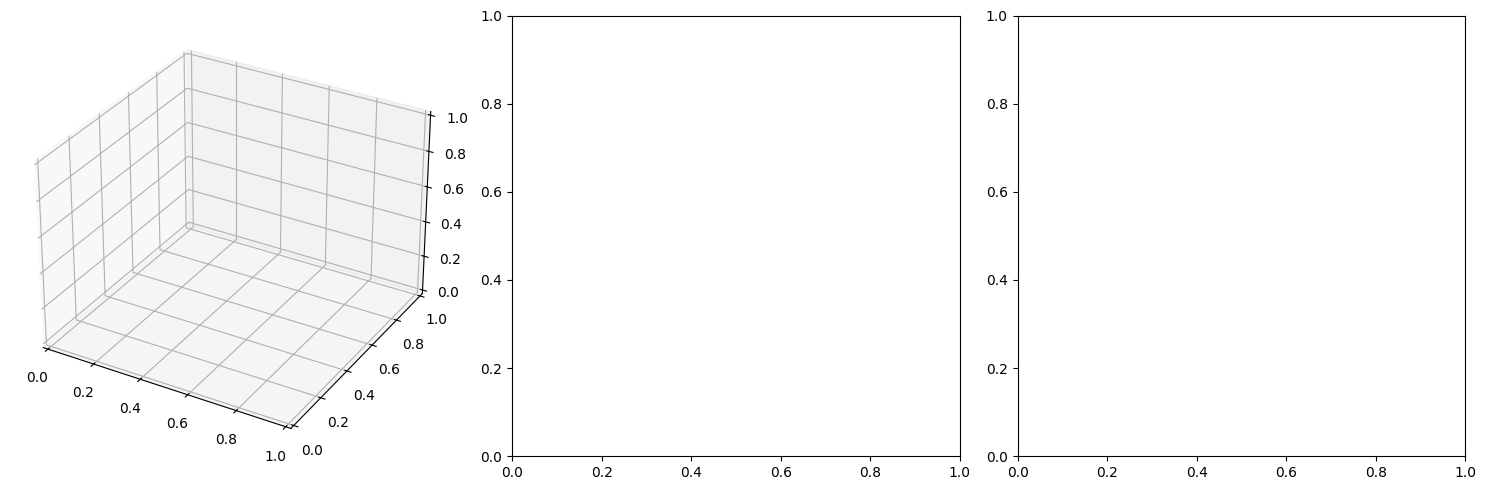

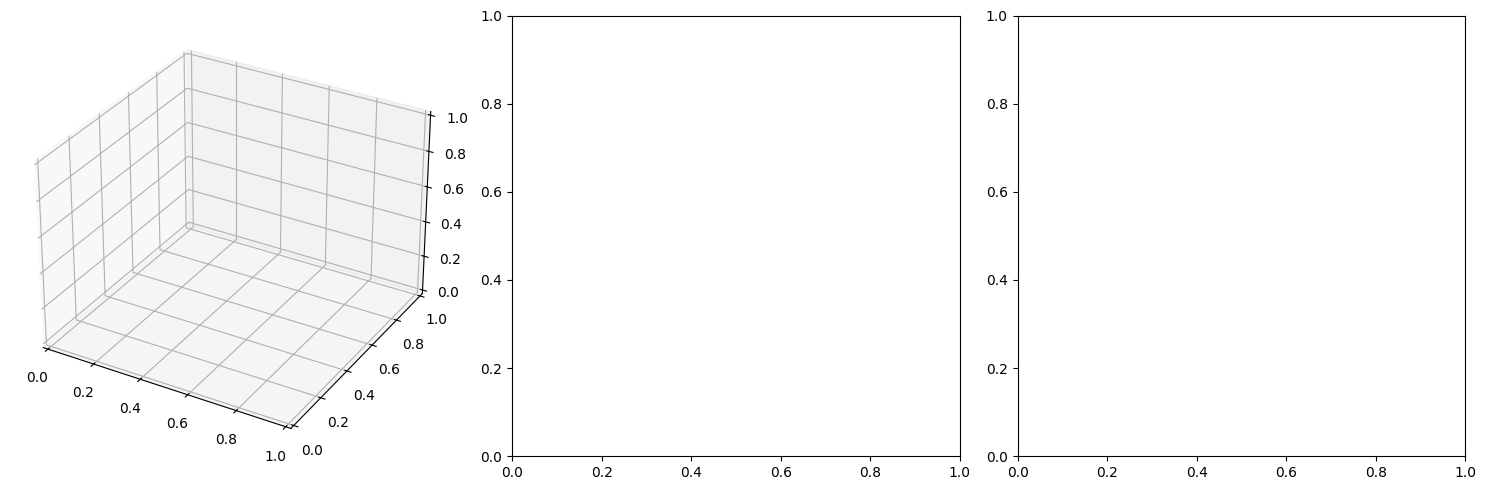

In [19]:
# import argparse
# parser = argparse.ArgumentParser()
# parser.add_argument('--n_iter', '-n', type=int, default=500)
# parser.add_argument('--n_directions', '-nd', type=int, default=8)
# parser.add_argument('--deltas_used', '-du', type=int, default=4)
# parser.add_argument('--step_size', '-s', type=float, default=0.02)
# parser.add_argument('--delta_std', '-std', type=float, default=0.0075)
# parser.add_argument('--rollout_length', '-r', type=int, default=100)

# parser.add_argument('--policy_type', type=str, default='linear')
# parser.add_argument('--dir_path', type=str, default='data')

# # for ARS V1 use filter = 'NoFilter'
# # for ARS V2 use filter = 'MeanStdFilter'
# parser.add_argument('--filter', type=str, default='MeanStdFilter')

# args = parser.parse_args()
# params = vars(args)
import os
run_ars(params)